## Анализ эффективности двух вариантов посадочной страницы
Туристическая компания разработала две версии посадочной страницы сайта с целью увеличения продаж туров

Метрики: *конверсия продаж и средний чек*

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest, proportions_chisquare
from scipy.stats import norm, t, shapiro, ttest_ind

matplotlib.style.use('seaborn-v0_8-paper')

### Исследование и преобразование данных

In [3]:
# Загружаем датасет
data = pd.read_csv('ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


In [4]:
display(data.info())
display(data.sort_values('date').head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


None

,user_id,date,group,purchase,price
245040,637212,2021-01-02,B,1,100000
27445,924138,2021-01-02,B,0,0
272484,659091,2021-01-02,A,0,0
27450,653194,2021-01-02,B,0,0
10854,810044,2021-01-02,A,0,0
136609,645986,2021-01-02,B,0,0
163708,939054,2021-01-02,B,0,0
256838,677911,2021-01-02,B,0,0
149133,894268,2021-01-02,B,0,0
281101,638214,2021-01-02,A,0,0


> * В датасете 294478 записи и 5 признаков. Три признака типа 'int' и два признака типа 'object' 
> * Признак 'date' имеет тип object, необходимо преобразование к типу datetime
> * Пропусков в данных нет

In [5]:
# Преобразование даты к типу datetime
data['date'] = pd.to_datetime(data['date'])
# Вывод диапазона дат
print(f'В датасете находятся наблюдения с {data['date'].min()} по {data['date'].max()}')

В датасете находятся наблюдения с 2021-01-02 00:00:00 по 2021-01-24 00:00:00


#### Проверка пересечений групп

In [6]:
# Найдем пользователей, которые оказались в обеих группах
users_in_both = set(data[data['group'] == 'A']['user_id'].values).intersection(set(data[data['group'] == 'B']['user_id'].values))
print(f'{len(users_in_both)} клиентов оказались в обеих группах')

# Подсчет количества сессий пользователей, оказавшихся в обеих группах
print(f"Количество сессий данных клиентов: {data[data['user_id'].isin(users_in_both)].shape[0]}")

# Удаляем пересечения
print('Удаляем пересечения')
data.drop(index=data[data['user_id'].isin(users_in_both)].index, inplace=True)
print(f'Количество записей в датасете: {data.shape}')

1895 клиентов оказались в обеих группах
Количество сессий данных клиентов: 3790
Удаляем пересечения
Количество записей в датасете: (290688, 5)


#### Исследование данных по группам

,min,max
group,,
A,2021-01-02,2021-01-24
B,2021-01-02,2021-01-24


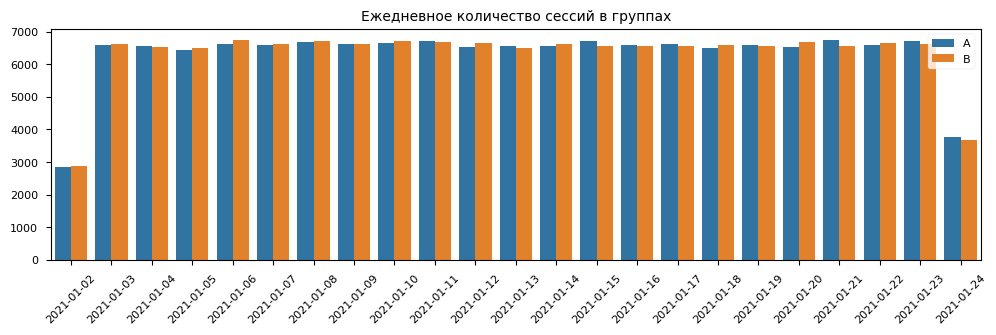

In [7]:
# Сравниваем временные интервалы в группах
display(data.groupby('group')['date'].agg(['min','max']))

# Распределение ежедневного количества сессий в группах
fig = plt.figure(figsize=(12,3))
sns.barplot(data.groupby('group', as_index=False)['date'].value_counts().sort_values('date'), 
            x='date', y='count', hue='group')
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize=8)
plt.tick_params('x', rotation=45, labelsize=8)
plt.legend(fontsize=8)
plt.title('Ежедневное количество сессий в группах', fontdict={'size': 10})
plt.show();

> * Количество пользовательских сессий равномерно распределено по дням ( за исключением первой и последней даты) и примерно равно по группам
> * Периоды наблюдений в группах совпадают 

#### Расчет покупательской способности по каждому из туров в группах
Туры:
* Таиланд — 100 000 рублей
* Турция — 60 000 рублей
* Мальдивы — 200 000 рублей
* Санкт-Петербург — 10 000 рублей
* Камчатка — 150 000 рублей

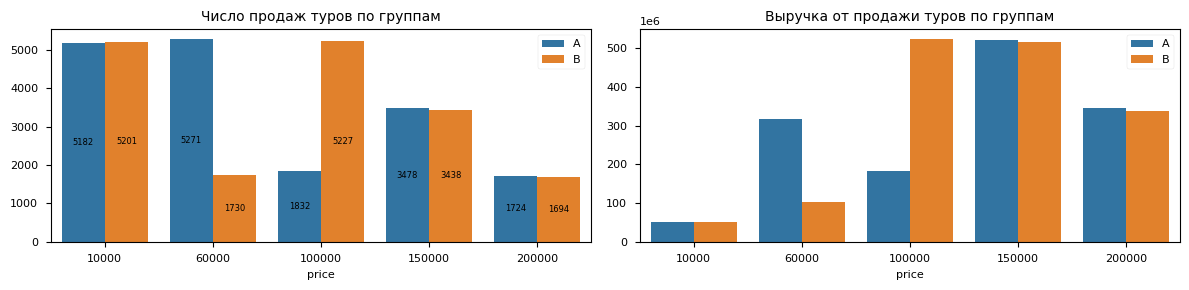

In [8]:
# Группируем данные по турам
tour_totals = data[data['price'] != 0].groupby(['group', 'price']).agg({
    'purchase': 'sum',
    'price': 'sum'
}).rename(columns={'price': 'revenue'}).reset_index()

# Выводим данные
fig, (axPurch, axRev) = plt.subplots(1,2,figsize=(12,3))
sns.barplot(tour_totals, x='price', y='purchase', hue='group', ax=axPurch)
axPurch.set_ylabel('')
axPurch.get_xaxis().label.set_size(8)
axPurch.tick_params(labelsize=8)
axPurch.bar_label(axPurch.containers[0], fontsize=6, label_type='center', color='black')
axPurch.bar_label(axPurch.containers[1], fontsize=6, label_type='center', color='black')
axPurch.legend(fontsize=8)
axPurch.set_title('Число продаж туров по группам', fontdict={'size': 10})
sns.barplot(tour_totals, x='price', y='revenue', hue='group', ax=axRev)
axRev.set_ylabel('')
axRev.get_xaxis().label.set_size(8)
axRev.tick_params(labelsize=8)
axRev.legend(fontsize=8)
axRev.ticklabel_format(axis='y', scilimits=(6,6))
axRev.set_title('Выручка от продажи туров по группам', fontdict={'size': 10})
fig.tight_layout()
plt.show();


> * Более всего продано туров в Санкт-Петербург (10000), продажи примерно равны в обеих группах. Выручка от продажи этих туров наименьшая 
> * Туров в Турцию (60000) в группе A продано в три раза больше, чем в группе B
> * Продажи туров в Таиланд в группе B больше в три раза по сравнению с продажами в группе A, это самое большое количество продаж по всем группам и турам
> * Выручка от продажи туров в Таиланд в группе B наивысшая среди продаж по всем турам и группам
> * Туров на Камчатку продано примерно одинаково в обеих группах, продажи составляют около двух третей от продаж туров в Таиланд группы В. Суммарная выручка по двум группам по данной позиции наивысшая
> * Туров на Мальдивы (200000) продано меньше всего в обеих группах, но выручка от их продажи на втором месте после туров на Камчатку, что обеспечивается высокой стоимостью

#### Обобщенные показатели для групп

In [9]:
# Обобщенные данные по группам
totals = data.groupby('group').agg({
        'user_id': 'count',
        'purchase': 'sum',
        'price': 'sum'
        }).rename(columns={'user_id': 'size'})

totals = pd.concat([totals,
                    pd.DataFrame({'size': totals['size'].iloc[1] - totals['size'].iloc[0],
                            'purchase': totals['purchase'].iloc[1] - totals['purchase'].iloc[0],
                            'price': totals['price'].iloc[1] - totals['price'].iloc[0]},
                            index = ['difference'])])


# Средний чек и конверсия по группам
totals['mean_cheque'] = totals['price'] / totals['size'].round(2) # mean cheque by group
totals['conversion'] = totals['purchase'] / totals['size'] # conversion by group
totals.loc['difference'] = totals.loc['B'] - totals.loc['A'] # metrics difference
# Output data
display(totals.style.format({'mean_cheque': "{:.2f}"}))


,size,purchase,price,mean_cheque,conversion
A,145307,17487,1417780000,9757.13,0.120345
B,145381,17290,1533010000,10544.78,0.118929
difference,74,-197,115230000,787.64,-0.001416


> * Группы сбалансированы по размеру и числу продаж
> * Конверсия в группе A выше, чем в группе B, но разница меньше 0.002
> * Средний чек выше в группе B, разница составляет 8% от среднего чека группы A и 7% от среднего чека группы B

### Cравнение метрик в группах

In [10]:
# Группируем данные по датам и группам
daily_data = data.groupby(['date', 'group'], as_index=False).agg({
    'user_id': 'count',
    'purchase': 'sum',
    'price': 'sum'
}).rename(columns={'user_id': 'users'})
# Ежедневный средний чек
daily_data['mean_cheque'] = data.groupby(['date', 'group'])['price'].mean().values
# Ежедневная конверсия
daily_data['conversion'] = daily_data['purchase'] / daily_data['users']

#### Исследование конверсии продаж

                mean    median
A           0.120433  0.120281
B           0.118977  0.118286
difference  0.001456  0.001994


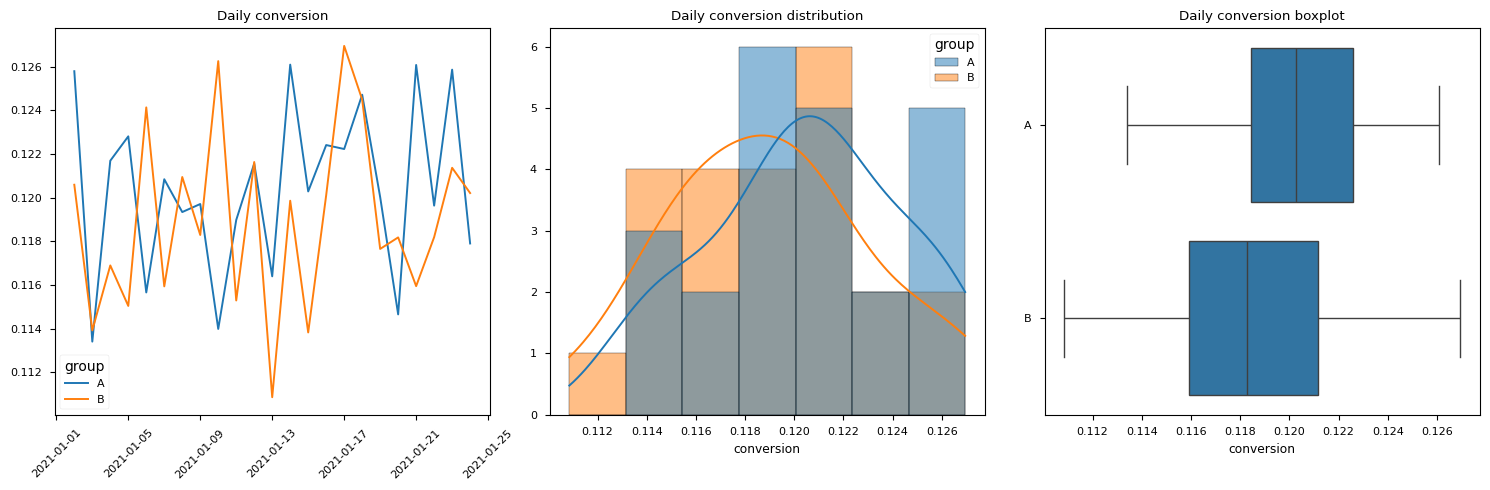

In [11]:
# Процедура построения графиков визуального стравнения
def visual_compare(feature):
    # Группировка метрик
    metrics = daily_data.groupby('group')[feature].agg(['mean', 'median'])
    metrics = pd.concat([metrics,
                        pd.DataFrame({'mean': metrics['mean'].loc['A'] - metrics['mean'].loc['B'],
                                'median': metrics['median'].loc['A'] - metrics['median'].loc['B']},
                                index = ['difference'])
    ])
    print(metrics)

    # Построение графиков
    fig, (axLine, axHist, axBox) = plt.subplots(1,3,figsize=(15,5))
    sns.lineplot(daily_data, x='date', y=feature, hue='group', ax=axLine)
    axLine.set_xlabel('')
    axLine.set_ylabel('')
    axLine.set_title('Daily '+feature)
    axLine.tick_params('x', rotation=45)
    sns.histplot(daily_data, x=feature, hue='group', kde=True, ax=axHist)
    axHist.set_ylabel('')
    axHist.set_title('Daily '+feature+' distribution')
    sns.boxplot(daily_data, x=feature, y='group', ax=axBox)
    axBox.set_ylabel('')
    axBox.set_title('Daily '+feature+' boxplot')
    fig.tight_layout()
    plt.show();

visual_compare('conversion')

> * Среднее значение и медиана выше в группе A
> * Разброс значений выше в группе В
> * Ежедневная конверсия не стабилизирована 
> 
> *Рассчитаем кумулятивную конверсию для стабилизации метрик*

##### Кумулятивная конверсия продаж

                mean    median
A           0.119758  0.119479
B           0.118297  0.118644
difference  0.001462  0.000835


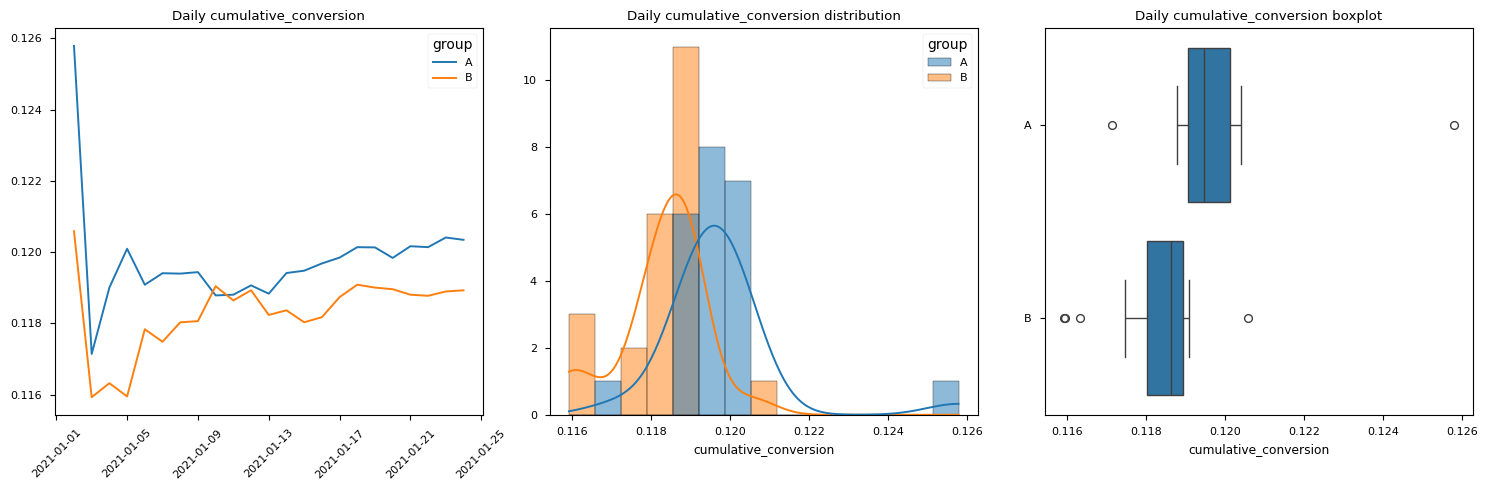

In [12]:
# Рассчитаем кумулятивную конверсию
daily_data['cumulative_purchase'] = daily_data.groupby('group')['purchase'].cumsum()
daily_data['cumulative_users'] = daily_data.groupby('group')['users'].cumsum()
daily_data['cumulative_conversion'] = daily_data['cumulative_purchase'] / daily_data['cumulative_users']

visual_compare('cumulative_conversion')

> * Метрики стабилизировались. Кумулятивная конверсия в группе A стабильно выше, чем в группе B за исключением промежутка с 10-01-2021 по 12-01-2021.
> * Кумулятивное среднее и медиана в группе A выше, чем в группе B
> 
> *Так как, согласно анализу выше, разница конверсий в группах не превышает 0.002, необходимо провести тесты для выяснения статистической значимости разниц конверсий*

##### Z-test для пропорции

* $H_0$: *конверсия продаж в группе A совпадает с конверсией продаж в группе B*
* $H_1$: *конверсии продаж в группах A и B не совпадают*

Уровень значимости alpha = 0.05

In [13]:
alpha = 0.05 # уровень значимости
# Выполняем тест
_, p_value = proportions_ztest(count=totals.drop(index='difference')['purchase'].values,
                        nobs=totals.drop(index='difference')['size'].values,
                        alternative='two-sided')
# Анализируем результаты
if p_value < alpha:
    print(f"p-value={p_value:.3f} < {alpha}.\nОтвергаем нулевую гипотезу в пользу альтернативной: конверсии продаж в группах различны")
else:
    print(f"p-value={p_value:.3f} >= {alpha}.\nНе можем отбросить нулевую гипотезу: конверсии продаж в группах A и B равны")

p-value=0.239 >= 0.05.
Не можем отбросить нулевую гипотезу: конверсии продаж в группах A и B равны


> Проверим равенство конверсий с помощью еще одного теста

##### Хи-квадрат для пропорций
* $H_0$: *конверсия продаж в группе A совпадает с конверсией продаж в группе B*
* $H_1$: *конверсии продаж в группах A и B не совпадают*

Уровень значимости alpha = 0.05

In [14]:
alpha = 0.05 # уровень значимости
# Выполняем тест
_, p_value, _ = proportions_chisquare(count=totals.drop(index='difference')['purchase'].values,
                        nobs=totals.drop(index='difference')['size'].values)

# Анализируем результаты
if p_value < alpha:
    print(f"p-value={p_value:.3f} < {alpha}.\nОтвергаем нулевую гипотезу в пользу альтернативной: конверсии продаж в группах различны")
else:
    print(f"p-value={p_value:.3f} >= {alpha}.\nНе можем отбросить нулевую гипотезу: конверсии продаж в группах A и B равны")

p-value=0.239 >= 0.05.
Не можем отбросить нулевую гипотезу: конверсии продаж в группах A и B равны


> **Конверсии продаж в тестовой и контрольной группах совпадают**

#### Исследование среднего чека

                    mean        median
A            9753.234490   9777.179602
B           10538.561154  10440.375303
difference   -785.326664   -663.195700


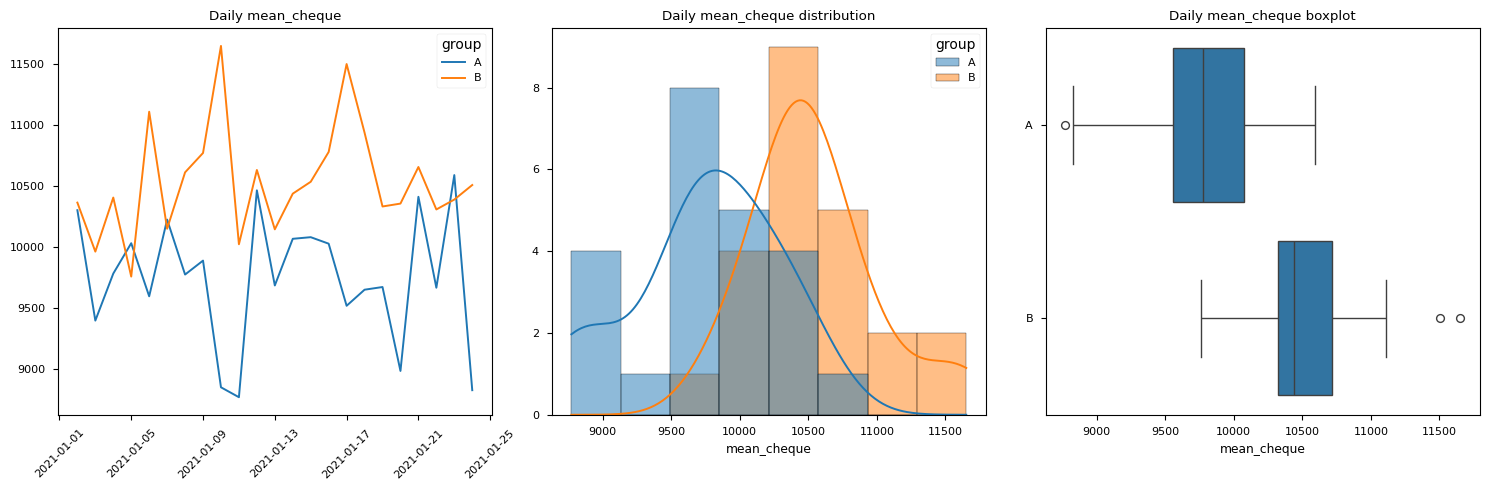

In [15]:
visual_compare('mean_cheque')

> * Среднее значение и медиана выше в группе B
> * Разброс данных больше в группе A. В обеих групппах есть выбросы
> * Распределение в обеих группах похоже на нормальное
> * Ежедневный средний чек преимущественно выше в группе B, но метрики не стабилизированы
> 
> *Рассчитаем кумулятивный средний чек для стабилизации метрик*

##### Кумулятивный средний чек

                    mean        median
A            9774.360964   9753.577327
B           10438.588569  10494.282611
difference   -664.227605   -740.705285


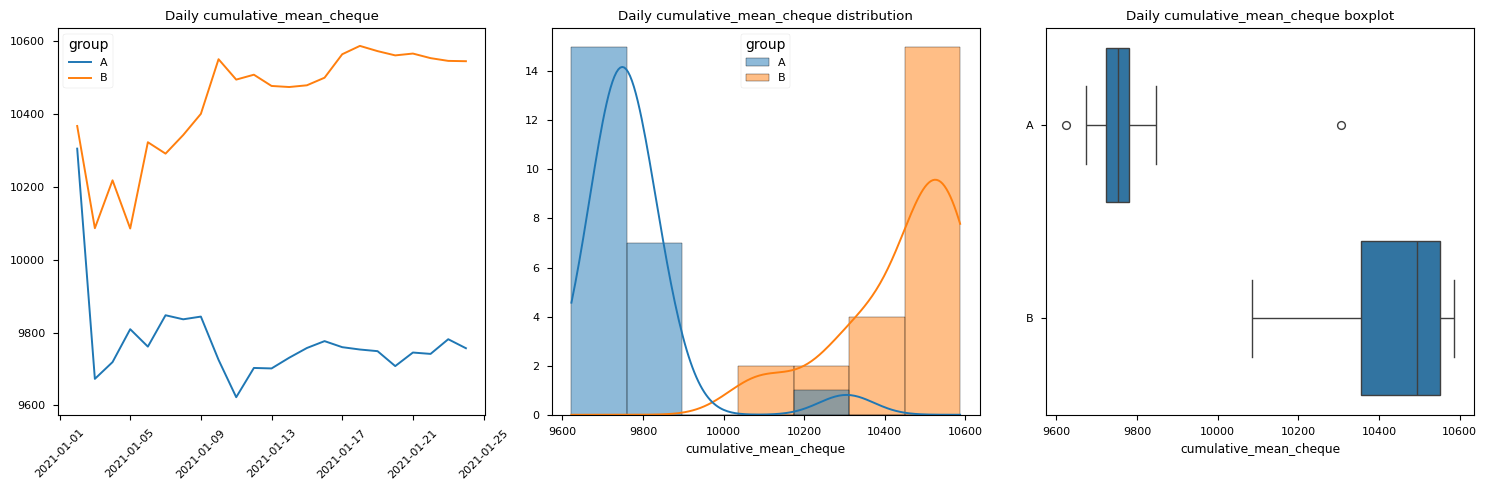

In [16]:
# Расчет ежедневного кумулятивного среднего чека
daily_data['cumulative_price'] = daily_data.groupby('group')['price'].cumsum()
daily_data['cumulative_mean_cheque'] = daily_data['cumulative_price'] / daily_data['cumulative_users']
visual_compare('cumulative_mean_cheque')

> * Кумулятивный ежедневный средний чек выше в группе B на всем диапазоне наблюдений
> * Среднее и медиана кумулятивного среднего чека заметно выше в группе B
>
> *Подтвердим наблюдения при помощи статистических тестов*

##### Проверка на нормальное распределение среднего чека
используется тест Шапиро-Уилка
* $H_0$: *данные распределены нормально*
* $H_1$: *данные не распределены нормально*

Уровень значимости alpha=0.05

In [17]:
# Процедура проверки на нормальность
def is_normal(x, alpha=0.05):
    res = shapiro(x)
    if res.pvalue < alpha:
        print("данные не распределены нормально")
    else:
        print("данные распределены нормально")

print('В группе A', end=' ')
is_normal(daily_data[daily_data['group'] == 'A']['mean_cheque'])
print('В группе B', end=' ')
is_normal(daily_data[daily_data['group'] == 'B']['mean_cheque'])

В группе A данные распределены нормально
В группе B данные распределены нормально


> * Признак среднего чека - числовой
> * Выборки обеих групп распределены нормально
> * Группы независимы
>
> *Используем t-критерий для сравнения метрик среднего чека*

##### t-критерий
* $H_0$: *средний чек в группе A равен среднему чеку группы B*
* $H_1$: *значения среднего чека в группах A и B не равны*

Уровень значимости alpha=0.05

In [18]:
alpha = 0.05 # уровень значимости
# Выполняем тест
res = ttest_ind(daily_data[daily_data['group'] == 'A']['mean_cheque'],
                   daily_data[daily_data['group'] == 'B']['mean_cheque'])
# Анализируем результат
if res.pvalue < alpha:
    print(f'p-value={res.pvalue:.3f} <= {alpha}\nОтвергаем нулевую гипотезу в пользу альтернативной: значения среднего чека в группах различны')
else:
    print(f"p-value={res.pvalue:.3f} > {alpha}\nНе можем отбросить нулевую гипотезу: конверсии продаж в группах A и B равны")

p-value=0.000 <= 0.05
Отвергаем нулевую гипотезу в пользу альтернативной: значения среднего чека в группах различны


> **Средний чек в группе B выше, чем в группе A**

### Доверительные интервалы

#### Доверительный интервал конверсии

Конверсия - бинарный категориальный признак. Строим доверительный интервал для пропорций

In [19]:
# Процедура построения доверительного интервала для пропорций
def get_ci_proportion(x_p, n, gamma=0.95):
    alpha = 1-gamma
    z = -norm.ppf(alpha/2)
    bottom = x_p - z * (x_p * (1-x_p) / n)**0.5
    top = x_p + z * (x_p * (1-x_p) / n)**0.5
    return bottom, top

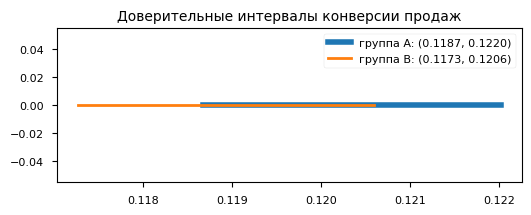

In [20]:
# Вычисляем доверительные интервалы для групп
bottom_a, top_a = get_ci_proportion(x_p=totals.loc['A']['conversion'],
                                     n=totals.loc['A']['size']) # группа A
bottom_b, top_b = get_ci_proportion(x_p=totals.loc['B']['conversion'],
                                     n=totals.loc['B']['size']) # группа B

# Графический вывод результатов
fig = plt.figure(figsize=(6,2))
sns.lineplot(x=[bottom_a, top_a], y=[0,0], linewidth=4, label=f'группа A: ({bottom_a:.4f}, {top_a:.4f})')
sns.lineplot(x=[bottom_b, top_b], y=[0,0], linewidth=2, label=f'группа B: ({bottom_b:.4f}, {top_b:.4f})')
plt.tick_params(labelsize=8)
plt.title('Доверительные интервалы конверсии продаж', fontdict={'size': 10})
plt.legend(fontsize=8)
plt.show();

> Доверительные интервалы пересекаются, но не совпадают. Построем доверительный интервал для разницы значений

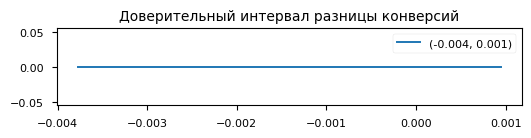

In [21]:
# Вычисление доверительного интервала разницы значений
alpha = 1 - 0.95
z = -norm.ppf(alpha/2)
x_p_a = totals.loc['A']['conversion'] # конверсия группы A
n_a = totals.loc['A']['size'] # размер группы A
x_p_b = totals.loc['B']['conversion'] # конверсия группы B
n_b = totals.loc['B']['size'] # размер группы B

bottom_diff = x_p_b - x_p_a - z * (x_p_a * (1-x_p_a) / n_a + x_p_b * (1-x_p_b)/n_b)**0.5
top_diff = x_p_b - x_p_a + z * (x_p_a * (1-x_p_a) / n_a + x_p_b * (1-x_p_b)/n_b)**0.5

fig = plt.figure(figsize=(6,1))
sns.lineplot(x=[bottom_diff, top_diff], y=[0,0], label=f'({bottom_diff:.3f}, {top_diff:.3f})')
plt.title('Доверительный интервал разницы конверсий', fontdict={'size': 10})
plt.tick_params(labelsize=8)
plt.legend(fontsize=8);
plt.show();

> Доверительный интервал разницы значений содержит ноль и его длина составляет 0.005. Мы получили дополнительное подтверждение равенства конверсий в группах

#### Доверительный интервал среднего чека
Признак среднего чека нормально распределен, но нам неизвестны параметры генеральной совокупности: среднее и стандартное отклонение. Для расчета интервала используем t-распределение

In [22]:
# Процедура расчета доверительного интервала
def get_ci_t(x_p, x_std, n, gamma=0.95):
    alpha = 1 - gamma
    k = n - 1
    t_crit = -t.ppf(alpha/2, k)
    bottom = x_p - t_crit * x_std / n**0.5
    top = x_p + t_crit * x_std / n**0.5
    return bottom, top

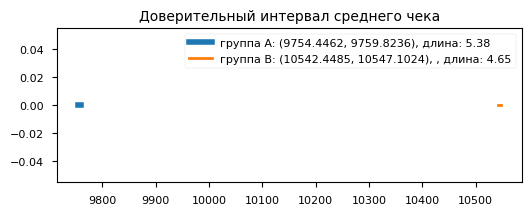

In [23]:
# Расчет доверительных интервалов
# группа A
bottom_a, top_a = get_ci_t(x_p = totals.loc['A']['mean_cheque'],
                           x_std = daily_data[daily_data['group'] == 'A']['mean_cheque'].std(),
                           n = totals.loc['A']['size'])

# Группа B
bottom_b, top_b = get_ci_t(totals.loc['B']['mean_cheque'],
                           daily_data[daily_data['group'] == 'B']['mean_cheque'].std(),
                           totals.loc['B']['size'])

# Графичекий вывод результатов
fig = plt.figure(figsize=(6,2))
sns.lineplot(x=[bottom_a, top_a], y=[0,0], linewidth=4, label=f'группа A: ({bottom_a:.4f}, {top_a:.4f}), длина: {top_a-bottom_a:.2f}')
sns.lineplot(x=[bottom_b, top_b], y=[0,0], linewidth=2, label=f'группа B: ({bottom_b:.4f}, {top_b:.4f}), , длина: {top_b-bottom_b:.2f}')
plt.title('Доверительный интервал среднего чека', fontdict={'size': 10})
plt.tick_params(labelsize=8)
plt.legend(fontsize=8)
plt.show();

> Доверительные интервалы не имеют пересечений.

### Заключение
* Конверсии продаж в обеих группах совпадают
* Средний чек в группе B выше на 787.64
* Увеличение среднего чека произошло за счет покупки клиентами группы B более дорогих туров

**Посадочная страница в версии группы B дала увеличение выручки за счет выбора клиентами более дорогих туров, следовательно, версия сайта группы B предпочтительнее на данном этапе. Однако, отсутствие роста конверсии дает основание для дальнейших исследований с целью выявления факторов, способных поднять конверсию продаж.**